In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np

# file path
mouse_metadata_path = "resources/Mouse_metadata.csv"
study_results_path = "resources/Study_results.csv"

# create dataframes
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)


In [2]:
# drop duplicates and store as clean df
mouse_df = pd.merge(mouse_metadata, study_results, on="Mouse ID", how="outer")
mouse_df.drop_duplicates(subset=["Mouse ID", "Timepoint", "Tumor Volume (mm3)", "Metastatic Sites"], inplace=True, ignore_index=True)
mouse_df

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1
...,...,...,...,...,...,...,...,...
1887,z969,Naftisol,Male,9,30,25,63.145652,2
1888,z969,Naftisol,Male,9,30,30,65.841013,3
1889,z969,Naftisol,Male,9,30,35,69.176246,4
1890,z969,Naftisol,Male,9,30,40,70.314904,4


In [3]:
# check counts from clean df
print(mouse_df["Mouse ID"].value_counts())
print(len(mouse_df["Mouse ID"]))

g989    12
k403    10
j365    10
j984    10
k210    10
        ..
v199     1
t573     1
f932     1
b447     1
u153     1
Name: Mouse ID, Length: 249, dtype: int64
1892


<AxesSubplot:title={'center':'Number of Mice treated by Drug Regimen'}, xlabel='Time Interval (5 days)', ylabel='Total Number of Mice'>

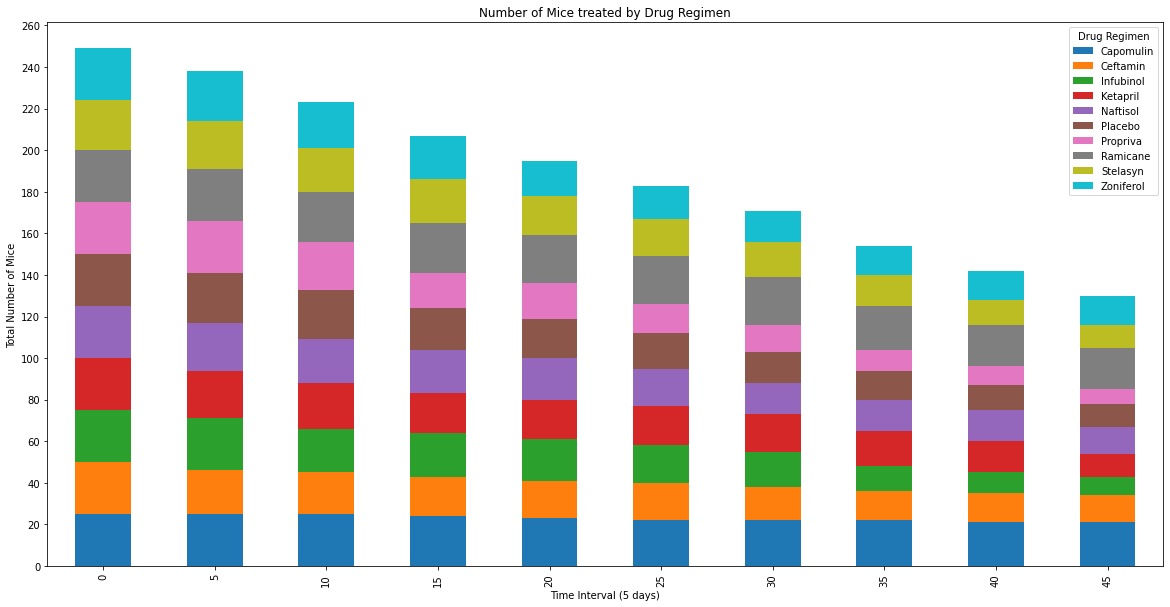

In [4]:
g_t_r = mouse_df[["Mouse ID", "Timepoint", "Drug Regimen"]]
g_t_r_grp = g_t_r.groupby(["Timepoint", "Drug Regimen"])["Timepoint"].count().unstack("Drug Regimen")
y_ticks = np.arange(0, 280, 20.0)
g_t_r_grp.plot(kind='bar', stacked=True, figsize=(20,10), title="Number of Mice treated by Drug Regimen", xlabel="Time Interval (5 days)", ylabel="Total Number of Mice", yticks=y_ticks)

In [5]:
# generate pie plot for distribution by sex of ID using DataFrame.plot
df_copy2 = mouse_df.copy()
df_copy2.drop_duplicates(subset=["Mouse ID", "Sex"], inplace=True, ignore_index=True)
groupby_sex = df_copy2[["Mouse ID", "Sex"]].groupby("Sex")
sex_count_series = groupby_sex["Mouse ID"].count()
ID_sex_df = pd.DataFrame(sex_count_series)
ID_sex_df


,Mouse ID
Sex,
Female,124
Male,125


<AxesSubplot:ylabel='Mouse ID'>

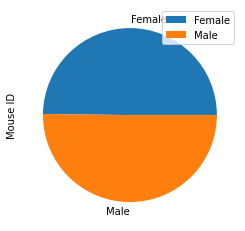

In [6]:
ID_sex_df.plot(kind="pie", y="Mouse ID")

In [15]:
# calculate final tumor volume of each mouse across four of the most promising treatment regimens: Capomulin, Ramicane, Infubinol, and Ceftamin
promsing_treatments_df = mouse_df.loc[(mouse_df["Drug Regimen"] == "Capomulin") | (mouse_df["Drug Regimen"] == "Ramicane") | (mouse_df["Drug Regimen"] == "Infubinol") | (mouse_df["Drug Regimen"] == "Ceftamin"), ["Drug Regimen", "Mouse ID", "Tumor Volume (mm3)"]]
group_treatment = promsing_treatments_df.groupby(["Drug Regimen", "Mouse ID"])
tumor_vol = group_treatment["Tumor Volume (mm3)"].sum()
tumor_vol_df = pd.DataFrame(tumor_vol)
tumor_vol_df

Tumor Volume (mm3)
Drug Regimen Mouse ID                    
Capomulin    b128              419.636356
             b742              400.836993
             f966              182.529864
             g288              419.900966
             g316              446.133439
...                                   ...
Ramicane     s508              360.501562
             u196              455.763948
             w678               88.166373
             y449              181.439088
             z578              384.115100

[100 rows x 1 columns]

In [10]:
# Calculate the quartiles and IQR and quantitatively determine if there are any potential outliers across all four treatment regimens.
quartiles = tumor_vol_df["Tumor Volume (mm3)"].quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
middleq = quartiles[0.50]

# IQR
iqr = upperq-lowerq

# bounds
lower_bound = lowerq - (1.5 * iqr)
upper_bound = upperq + (1.5 * iqr)

print(f'lower quartile: {lowerq}')
print(f'middle quartile: {middleq}')
print(f'upper quartile: {upperq}')
print(f'iqr: {iqr}')
print(f'lower bound: {lower_bound}')
print(f'upper bound: {upper_bound}')
promsing_treatments_df

print(f'largest tumor vol: {tumor_vol_df["Tumor Volume (mm3)"].max()}')
print(f'smallest tumor vol: {tumor_vol_df["Tumor Volume (mm3)"].min()}')

lower quartile: 340.0010610275
middle quartile: 394.845840265
upper quartile: 449.984559655
iqr: 109.98349862750001
lower bound: 175.02581308624997
upper bound: 614.95980759625
largest tumor vol: 587.4094294700001
smallest tumor vol: 45.0


In [11]:
# construct outlier dataframe to identify outliers
pt_reset_index = tumor_vol_df.reset_index()
outlier_IDs_df = pt_reset_index.loc[(pt_reset_index["Tumor Volume (mm3)"] < lower_bound) | (pt_reset_index["Tumor Volume (mm3)"] > upper_bound)].set_index("Mouse ID")
outlier_IDs_df


,Drug Regimen,Tumor Volume (mm3)
Mouse ID,,
w150,Capomulin,124.154476
b447,Ceftamin,45.000000
h531,Ceftamin,92.784682
l558,Ceftamin,137.593624
t573,Ceftamin,45.000000
u153,Ceftamin,45.000000
x226,Ceftamin,45.000000
c326,Infubinol,81.321346
m756,Infubinol,92.010364


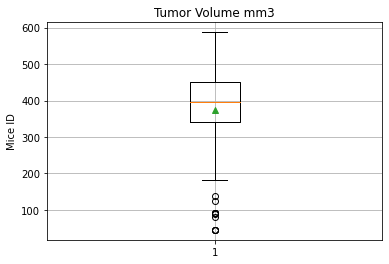

In [12]:
# box and whisker plot for outliers in promising treatments
fig1, ax1 = plt.subplots()
ax1.set_title('Tumor Volume mm3')
ax1.set_ylabel('Mice ID')
plt.boxplot(tumor_vol_df["Tumor Volume (mm3)"], showmeans=True)
plt.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Tumor Volume (mm3)')

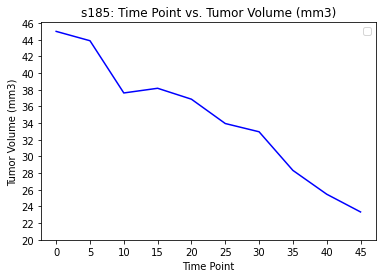

In [13]:
# generate line plot of tumor volume vs time point
id_cap_treatment = mouse_df.loc[mouse_df["Drug Regimen"] == "Capomulin", ["Drug Regimen", "Mouse ID", "Tumor Volume (mm3)", "Timepoint"]]

ran_id = id_cap_treatment.loc[id_cap_treatment["Mouse ID"] == "s185", ["Mouse ID", "Tumor Volume (mm3)", "Timepoint"]].set_index("Mouse ID")

plt.plot(ran_id["Timepoint"], ran_id["Tumor Volume (mm3)"], color="blue")
plt.legend(loc="best")
plt.title("s185: Time Point vs. Tumor Volume (mm3)")
plt.yticks(np.arange(min(ran_id["Tumor Volume (mm3)"]) -3.34, max(ran_id["Tumor Volume (mm3)"]) + 1.5, 2.0))
plt.xticks(np.arange(min(ran_id["Timepoint"]), max(ran_id["Timepoint"]) + 1, 5.0))
plt.xlabel("Time Point")
plt.ylabel("Tumor Volume (mm3)")

<AxesSubplot:xlabel='Weight (g)', ylabel='Tumor Volume (mm3)'>

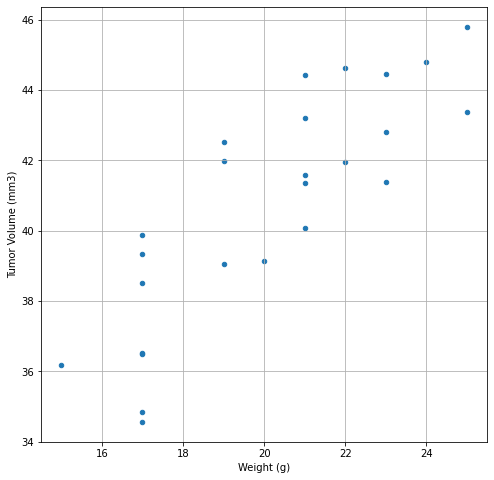

In [14]:
# generate scatter plot of mouse weight vs. average tumor volume for the Capomulin treatment regimen

capomulin_df = mouse_df.loc[mouse_df["Drug Regimen"] == "Capomulin", ["Mouse ID", "Tumor Volume (mm3)", "Weight (g)"]]
cap_group = capomulin_df.groupby(["Mouse ID", "Weight (g)"])
cap_group_ave = cap_group["Tumor Volume (mm3)"].mean()

ave_vol_vs_weight_df = pd.DataFrame(cap_group_ave).reset_index()
ave_vol_vs_weight_df.set_index("Mouse ID")

ave_vol_vs_weight_df.plot(kind="scatter", x="Weight (g)", y="Tumor Volume (mm3)", grid=True, figsize=(8,8))
